# Verification Steps for Autonomous Mode

This notebook will be used to test and debug the .py files for the Search and Sample assignment.

---
## Verify Perception.py
### Prep the test code

In [28]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
import perception
from drive_rover import RoverState

# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20
rover_worldmap = np.zeros((200, 200, 3)).astype(np.float)
rover_ground_truth = mpimg.imread('../calibration_images/map_bw.png')
rover_ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

print("World Map Dimenstions: {}".format(worldmap.shape))
print("Rover Dimenstions: X:{}, Y:{}, Yaw:{}".format(rover_xpos, rover_ypos, rover_yaw))

Rover = RoverState()
Rover.img = image
Rover.pos = (rover_xpos, rover_ypos)
Rover.yaw = rover_yaw
Rover.ground_truth = rover_ground_truth_3d
Rover.worldmap = rover_worldmap

World Map Dimenstions: (200, 200, 3)
Rover Dimenstions: X:[175.05269875], Y:[155.96834465], Yaw:[347.30227762]


### Analysis Steps Test Functions


In [36]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img, source, destination):
    #plot the test images
    fig = plt.figure(figsize=(12,9))
    plt.subplot(431)
    plt.tight_layout()
    plt.title("Original Image")
    plt.imshow(img, cmap='gray')
  
    # 2) Apply perspective transform
    warped = perception.perspect_transform(img, source, destination) 
    plt.subplot(432)
    plt.tight_layout()
    plt.title("Warped Image")
    plt.imshow(warped, cmap='gray')
    
    # 0 is obstacle data (Red)
    # 1 is rock sample data (Green)
    # 3 is navigatable terrain data (Blue)
    color_max_thresh = [(160, 160, 160), (200, 200, 75), (255, 255, 255)]
    color_min_thresh = [(0, 0, 0), (125, 100, 0), (160, 160, 160)]
    image_title = ["Obstacle", "Rock Sample", "Terrain"]
    for item_type in range(0, 3): 

        # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
        threshed = perception.color_thresh(warped, color_min_thresh[item_type], color_max_thresh[item_type])
        plt.subplot(434+item_type)
        plt.tight_layout()
        plt.title(image_title[item_type]+" Mask")
        plt.imshow(threshed, cmap='gray')

        # 4) Convert thresholded image pixel values to rover-centric coords
        xpix, ypix = perception.rover_coords(threshed)
        
        plt.subplot(437+item_type)
        plt.tight_layout()
        plt.plot(xpix, ypix, '.')
        plt.ylim(-160, 160)
        plt.xlim(0, 160)
        plt.title(image_title[item_type]+" in Rover Coordinates")

        # 5) Convert rover-centric pixel values to world coords
        scale = 10
        x_world, y_world = perception.pix_to_world(xpix, ypix,
                                        rover_xpos, rover_ypos,
                                        rover_yaw, worldmap.shape[0], scale)
        arrow_length = 100
        x_arrow = arrow_length * np.cos(rover_yaw[0])
        y_arrow = arrow_length * np.sin(rover_yaw[0])
        plt.subplot(4,3,10+item_type)
        plt.tight_layout()
        plt.plot(x_world, y_world, '.')
        plt.plot(rover_xpos, rover_ypos, 'go')
        plt.arrow(rover_xpos[0], rover_ypos[0], x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
        plt.ylim(0, 200)
        plt.xlim(0, 200)
        plt.title(image_title[item_type]+" in Rover Coordinates")
        
#Generate a map overlay
def generate_overlay(Rover, source, destination):
    # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((Rover.img.shape[0] + Rover.worldmap.shape[0], Rover.img.shape[1]*2, 3))
    # Next you can populate regions of the image with various output
    # Here I'm putting the original image in the upper left hand corner
    output_image[0:Rover.img.shape[0], 0:Rover.img.shape[1]] = Rover.img

    # Let's create more images to add to the mosaic, first a warped image
    warped = perception.perspect_transform(Rover.img, source, destination)
    # Add the warped image in the upper right hand corner
    output_image[0:Rover.img.shape[0], Rover.img.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(Rover.worldmap, 1, Rover.ground_truth, 0.5, 0)
    # Flip map overlay so y-axis points upward and add to output_image 
    output_image[Rover.img.shape[0]:, 0:Rover.worldmap.shape[1]] = np.flipud(map_add)
    
    return output_image

### Verify Using a Rock Calibration Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


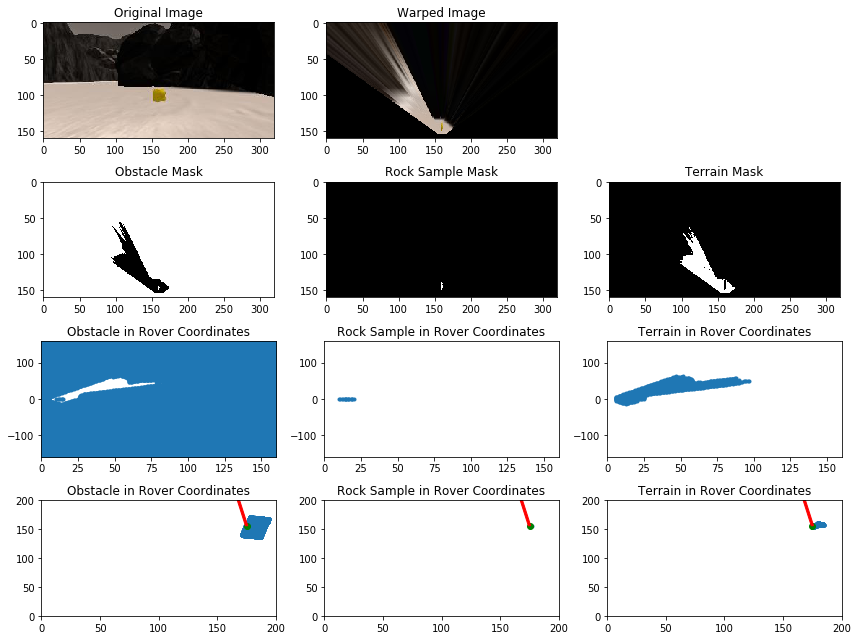

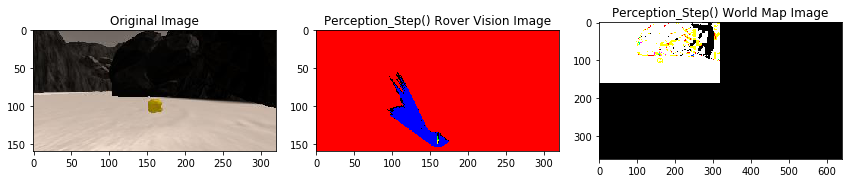

In [38]:
example_rock = '../calibration_images/example_rock1.jpg'
image_rock = mpimg.imread(example_rock)

####### Verify the independent analysis steps #######
rover_dst_size = 5 
rover_bottom_offset = 6
image_rock_source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
image_rock_destination = np.float32([[image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset], 
              [image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset],
              ]) 
process_image(image_rock, image_rock_source, image_rock_destination)

####### Verify the perception step for the autonomous mode #######
Rover.img = image_rock
perception.perception_step(Rover)
output_img = generate_overlay(Rover, image_rock_source, image_rock_destination)

fig = plt.figure(figsize=(12,9))
plt.subplot(1,3,1)
plt.tight_layout()
plt.title("Original Image")
plt.imshow(Rover.img, cmap='gray')

plt.subplot(1,3,2)
plt.tight_layout()
plt.title("Perception_Step() Rover Vision Image")
plt.imshow(Rover.vision_image, cmap='gray')

plt.subplot(1,3,3)
plt.tight_layout()
plt.title("Perception_Step() World Map Image")
plt.imshow(output_image, cmap='gray')

### Verify Using a Random Image from the Test Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


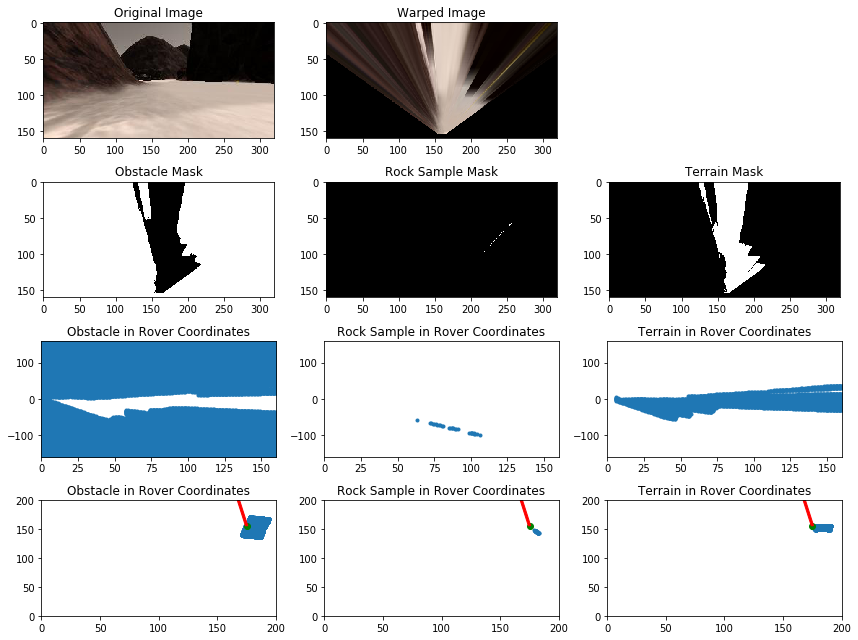

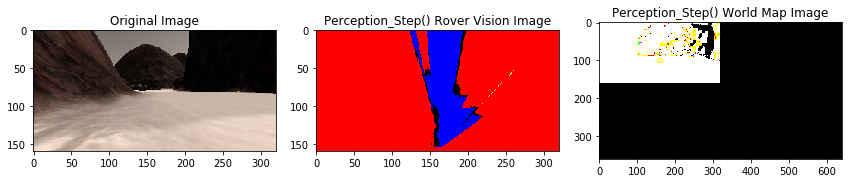

In [40]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])

####### Verify the independent analysis steps #######
rover_dst_size = 5 
rover_bottom_offset = 6
image_source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
image_destination = np.float32([[image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - rover_bottom_offset],
              [image_rock.shape[1]/2 + rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset], 
              [image_rock.shape[1]/2 - rover_dst_size, image_rock.shape[0] - 2*rover_dst_size - rover_bottom_offset],
              ]) 
process_image(image, image_source, image_destination)

####### Verify the perception step for the autonomous mode #######
Rover.img = image
perception.perception_step(Rover)
output_img = generate_overlay(Rover, image_source, image_destination)

fig = plt.figure(figsize=(12,9))
plt.subplot(1,3,1)
plt.tight_layout()
plt.title("Original Image")
plt.imshow(Rover.img, cmap='gray')

plt.subplot(1,3,2)
plt.tight_layout()
plt.title("Perception_Step() Rover Vision Image")
plt.imshow(Rover.vision_image, cmap='gray')

plt.subplot(1,3,3)
plt.tight_layout()
plt.title("Perception_Step() World Map Image")
plt.imshow(output_image, cmap='gray')